### **Mengatur Konfigurasi Pelatihan**

In [1]:
class cfg:
    # Model Training
    SKENARIO_EKSPERIMEN = '1'
    BATCH_SIZE = 16
    EPOCH = 20
    LEARNING_RATE = 0.0001
    #DROPOUT = 0.2
    NAMA_MODEL = f"U-Net_eksperimen_{SKENARIO_EKSPERIMEN}"

### **Inisialisasi Library yang Digunakan**

In [2]:
#library pengolahan data dan file
import numpy as np
import pandas as pd
import os
from glob import glob
import json

#library pengolahan citra
import cv2
import albumentations as A
from cv2 import imread, createCLAHE

#library visualisasi
import matplotlib.pyplot as plt

#library lain-lain
from tqdm import tqdm
import random
from IPython.display import clear_output
import time

#library deep learning dan machine learning
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


### **Inisialisasi Direktori Data**

In [3]:
image_path = os.path.join("/kaggle/input/skripsi-dataset-segmentasi-v2/Dataset-Segmentasi/images")
mask_path = os.path.join("/kaggle/input/skripsi-dataset-segmentasi-v2/Dataset-Segmentasi/masks")

In [4]:
pwd

'/kaggle/working'

### **Visualisasi *Sample* Data**

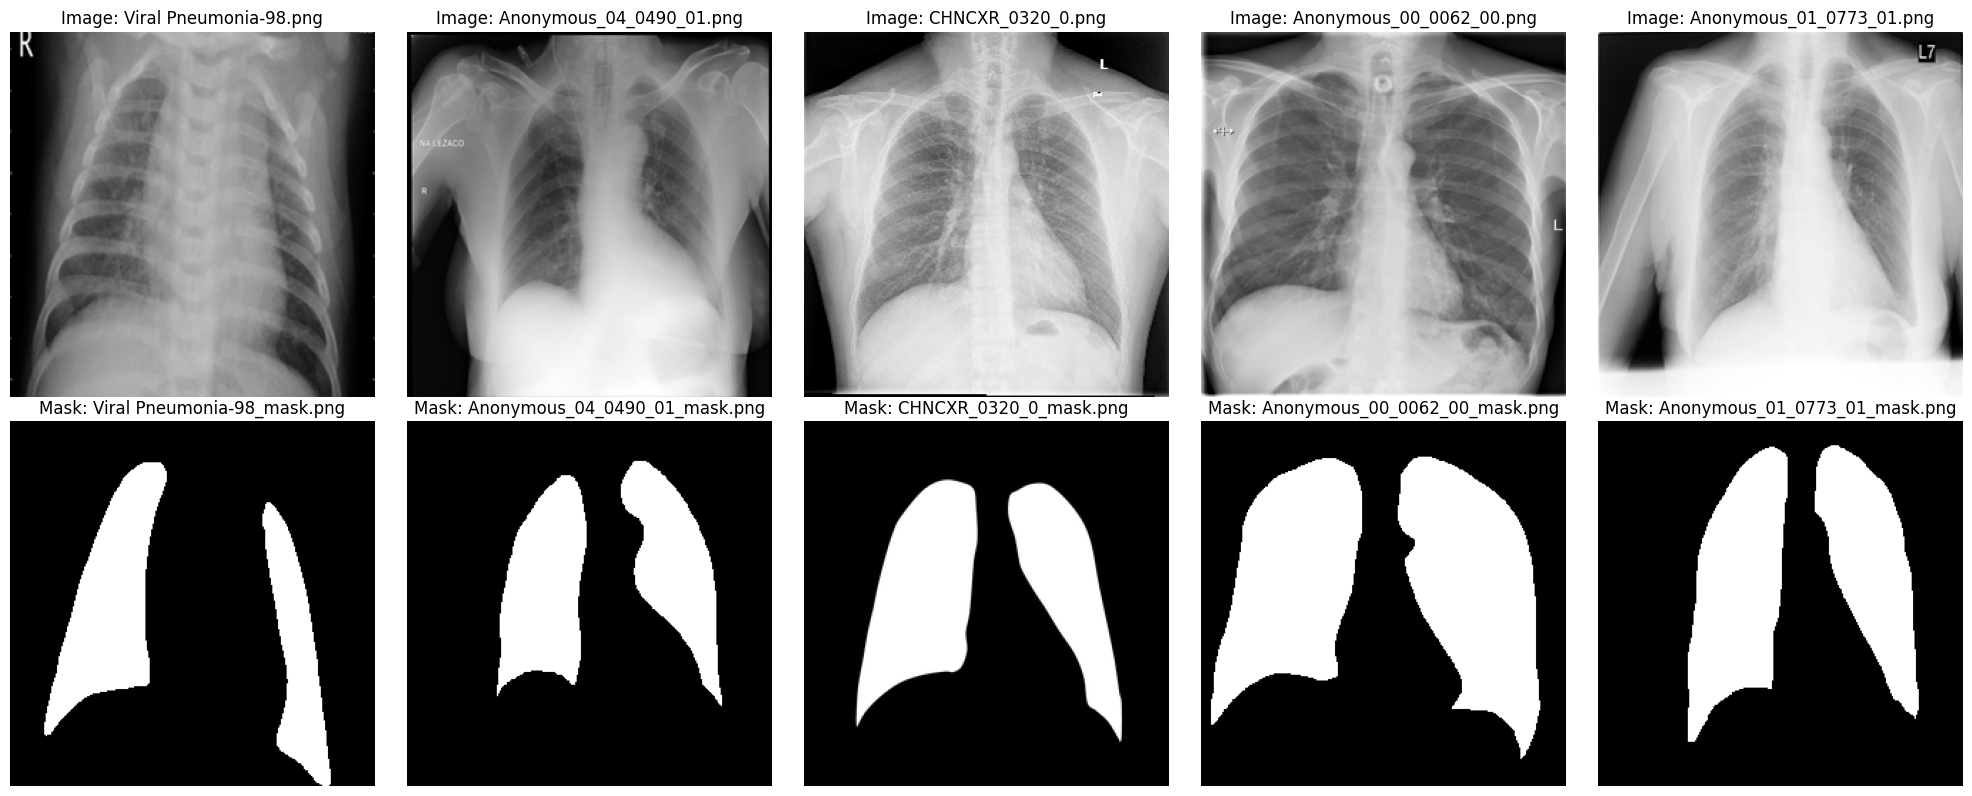

In [5]:
# Aktifkan inline plotting untuk menampilkan gambar di notebook
%matplotlib inline

# Tentukan path ke folder citra dan mask
image_path = "/kaggle/input/skripsi-dataset-segmentasi-v2/Dataset-Segmentasi/images"
mask_path = "/kaggle/input/skripsi-dataset-segmentasi-v2/Dataset-Segmentasi/masks"

# Ambil list nama file dari folder images
image_files = [f for f in os.listdir(image_path) if f.endswith('.png')]

# Pilih lima citra secara acak
random_images = random.sample(image_files, 5)

# Setup plotting (2 baris, 5 kolom)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Baris pertama: Plot gambar
for i, image_file in enumerate(random_images):
    # Load image
    image = cv2.imread(os.path.join(image_path, image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
    
    # Plot gambar di baris pertama
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Image: {image_file}")
    axes[0, i].axis('off')

# Baris kedua: Plot mask
for i, image_file in enumerate(random_images):
    # Load corresponding mask
    mask_file = image_file.replace('.png', '_mask.png')
    mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
    
    # Plot mask di baris kedua
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Mask: {mask_file}")
    axes[1, i].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

### **Tahap Pra-pemrosesan**

In [6]:
def preprocess_data(image_path, mask_path, X_shape=256, train_test_split_ratio=0.8, test_val_split_ratio=0.5, clahe_clip=2.0, clahe_grid=(8, 8)):
    # Load file gambar dan mask yang cocok
    image_files = set(f for f in os.listdir(image_path) if f.lower().endswith('.png'))
    mask_files = set(f for f in os.listdir(mask_path) if f.lower().endswith('.png'))

    matching_files = {f for f in image_files if f.replace('.png', '_mask.png') in mask_files}
    print(f"Jumlah file yang cocok: {len(matching_files)}")

    # Load dan preprocess gambar dan mask
    im_array, mask_array = [], []
    for i in tqdm(matching_files, desc="Loading and resizing data"):
        # Baca dan resize gambar dan mask
        im = cv2.resize(cv2.imread(os.path.join(image_path, i)), (X_shape, X_shape))[:, :, 0]
        mask = cv2.resize(cv2.imread(os.path.join(mask_path, i.replace('.png', '_mask.png'))), (X_shape, X_shape))[:, :, 0]
        im_array.append(im)
        mask_array.append(mask)

    # Konversi ke array numpy
    im_array = np.array(im_array).reshape(-1, X_shape, X_shape, 1)
    mask_array = np.array(mask_array).reshape(-1, X_shape, X_shape, 1)

    # Terapkan CLAHE
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
    im_array = np.array([clahe.apply(im.squeeze().astype(np.uint8))[:, :, np.newaxis] for im in im_array])

    # Normalisasi gambar dan thresholding mask
    im_array = im_array / 255.0
    mask_array = (mask_array > 127).astype(np.float32)

    # Split data menjadi train dan test
    train_vol, test_vol, train_seg, test_seg = train_test_split(im_array, mask_array, test_size=1-train_test_split_ratio, random_state=42)

    # Split data test menjadi test dan validasi
    test_vol, val_vol, test_seg, val_seg = train_test_split(test_vol, test_seg, test_size=test_val_split_ratio, random_state=42)

    return train_vol, train_seg, val_vol, val_seg, test_vol, test_seg

train_vol, train_seg, val_vol, val_seg, test_vol, test_seg = preprocess_data(image_path, mask_path)
print(f"Train set: {train_vol.shape}, {train_seg.shape}")
print(f"Test set: {test_vol.shape}, {test_seg.shape}")

Jumlah file yang cocok: 5907


Loading and resizing data: 100%|██████████| 5907/5907 [02:02<00:00, 48.27it/s]


Train set: (4725, 256, 256, 1), (4725, 256, 256, 1)
Test set: (591, 256, 256, 1), (591, 256, 256, 1)


### **Visualisasi Pembagian Data**

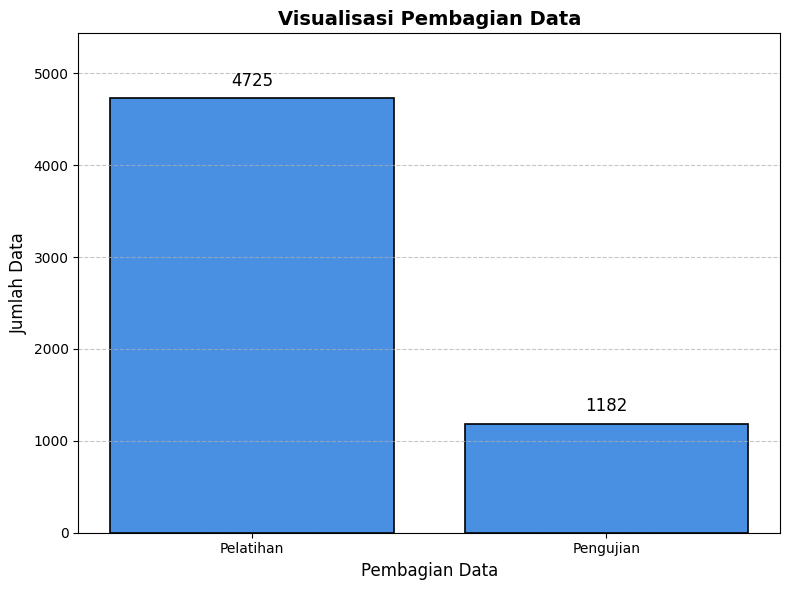

(4725, 256, 256, 1)
(4725, 256, 256, 1)
(591, 256, 256, 1)
(591, 256, 256, 1)
(591, 256, 256, 1)
(591, 256, 256, 1)


In [7]:
# Data untuk jumlah sample
labels = ['Pelatihan', 'Pengujian']
counts = [train_vol.shape[0], test_vol.shape[0] + val_vol.shape[0]]

# Membuat plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['#4A90E2', '#4A90E2'], edgecolor='black', linewidth=1.2)

# Menambahkan nilai di atas setiap bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + (0.02 * max(counts)),
             str(bar.get_height()), ha='center', va='bottom', fontsize=12, color='black')

# Menambahkan judul dan label
plt.title('Visualisasi Pembagian Data', fontsize=14, fontweight='bold')
plt.xlabel('Pembagian Data', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.ylim(0, max(counts) * 1.15)  # Tambahkan margin ekstra pada y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()

print(train_vol.shape)
print(train_seg.shape)
print(val_vol.shape)
print(val_seg.shape)
print(test_vol.shape)
print(test_seg.shape)

### **Pembuatan Model U-Net**

In [8]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    #pool1 = Dropout(cfg.DROPOUT)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    #pool2 = Dropout(cfg.DROPOUT)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder path
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer with 1 filter for binary segmentation
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### **Definisi Metrik yang Digunakan**

In [9]:
# Definisi metrik IOU
def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())  # Ubah prediksi menjadi biner (threshold = 0.5)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + 1e-10) / (union + 1e-10), axis=0)
    return iou

# Definisi metrik Precision
def precision_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_positives = K.sum(y_true * y_pred, axis=[1, 2, 3])
    predicted_positives = K.sum(y_pred, axis=[1, 2, 3])
    precision = K.mean((true_positives + 1e-10) / (predicted_positives + 1e-10), axis=0)
    return precision

# Definisi metrik Recall
def recall_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_positives = K.sum(y_true * y_pred, axis=[1, 2, 3])
    possible_positives = K.sum(y_true, axis=[1, 2, 3])
    recall = K.mean((true_positives + 1e-10) / (possible_positives + 1e-10), axis=0)
    return recall

# Definisi metrik F1-Score
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1_score

### **Kompilasi Mode U-Net**

In [10]:
# Example: Create model with input size (256, 256, 1)
model = unet(input_size=(256, 256, 1))

optimizer = Adam(learning_rate=cfg.LEARNING_RATE)

# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Ganti jika menggunakan loss lain
              metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

### **Membuat Fungsi Callback yang Digunakan**

In [11]:
# Callback untuk memplot metrik
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_metrics = {k: logs[k] for k in logs if 'val_' in k}
        print(f"Epoch {epoch + 1}: Validation Metrics: {val_metrics}")

# Callback untuk menyimpan history training ke file JSON
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        self.file_path = file_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            if key not in self.history:
                self.history[key] = []
            self.history[key].append(value)
        with open(self.file_path, 'w') as f:
            json.dump(self.history, f, indent=4)

# Callback untuk menghitung total waktu pelatihan
class TrainingTimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        self.end_time = time.time()
        self.training_duration = self.end_time - self.start_time
        print(f"Durasi pelatihan: {self.training_duration:.2f} detik")

# Callback untuk menghentikan lebih awal dan mengurangi learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Menyimpan history training
history_callback = SaveHistoryCallback(file_path='training_history.json')

# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Gabungkan semua callback
callbacks_list = [
    early_stopping,
    reduce_lr,
    checkpoint,
    history_callback,
    MetricsCallback(),
    TrainingTimeCallback()
]

### **Tahap Pelatihan Model U-Net**

In [12]:
history = model.fit(
    x=train_vol,
    y=train_seg,
    batch_size=cfg.BATCH_SIZE,
    epochs=cfg.EPOCH,
    validation_data=(val_vol, val_seg),
    callbacks=callbacks_list
)

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7800 - f1_metric: 0.2232 - iou_metric: 0.1900 - loss: 0.4727 - precision_metric: 0.8240 - recall_metric: 0.2111
Epoch 1: val_loss improved from inf to 0.15118, saving model to best_model.keras
Epoch 1: Validation Metrics: {'val_accuracy': 0.9423876404762268, 'val_f1_metric': 0.8816694021224976, 'val_iou_metric': 0.7873982191085815, 'val_loss': 0.1511775404214859, 'val_precision_metric': 0.973174512386322, 'val_recall_metric': 0.8065486550331116}
296/296 ━━━━━━━━━━━━━━━━━━━━ 176s 464ms/step - accuracy: 0.7803 - f1_metric: 0.2243 - iou_metric: 0.1910 - loss: 0.4722 - precision_metric: 0.8242 - recall_metric: 0.2122 - val_accuracy: 0.9424 - val_f1_metric: 0.8817 - val_iou_metric: 0.7874 - val_loss: 0.1512 - val_precision_metric: 0.9732 - val_recall_metric: 0.8065 - learning_rate: 1.0000e-04
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9549 - f1_metric: 0.9127 - iou_metric: 0.8379 - loss: 0.1153 - pr

### **Menyimpan Model**

In [13]:
model.save('kaggle/output/U-net-skenario-1.h5')

### **Visualisasi Hasil Pelatihan**

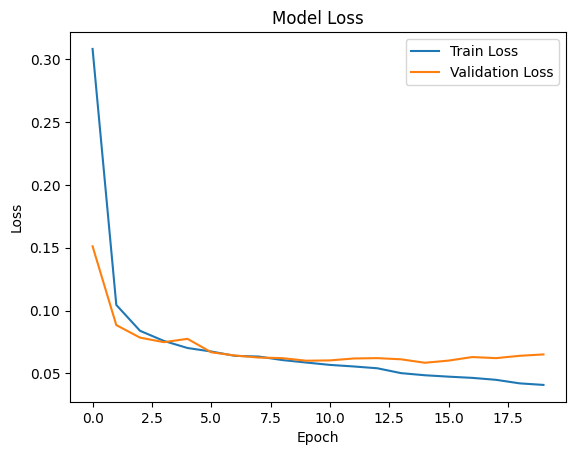

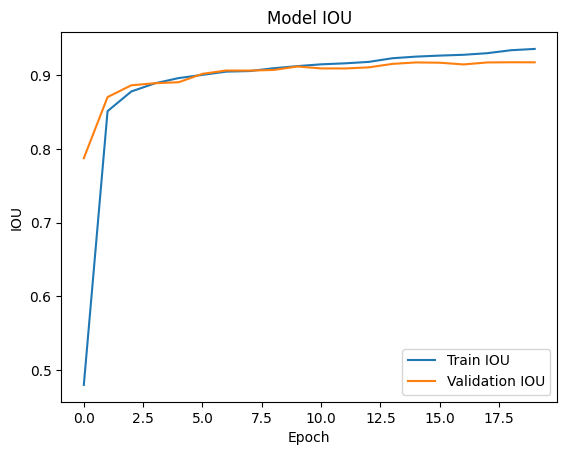

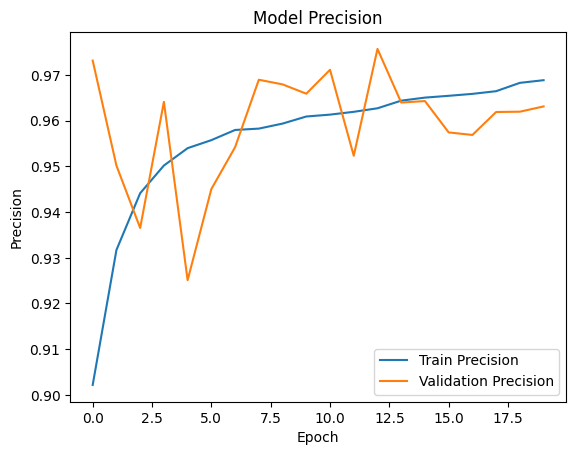

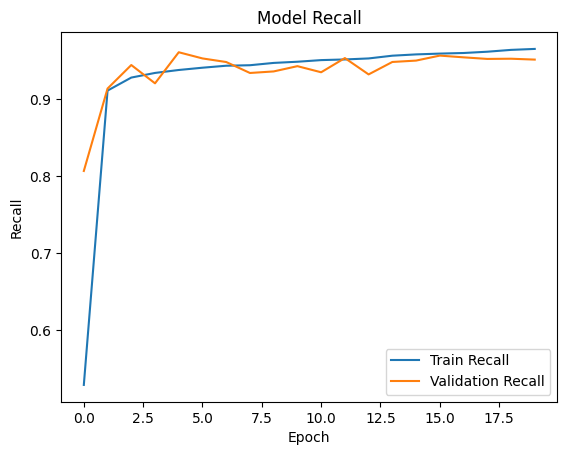

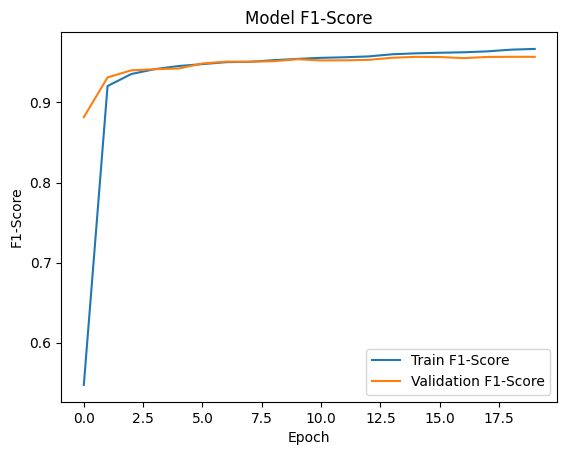

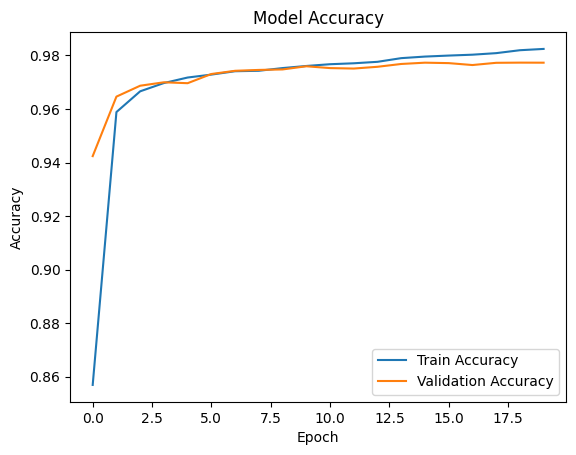

In [14]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot IOU for training & validation
plt.plot(history.history['iou_metric'], label='Train IOU')
plt.plot(history.history['val_iou_metric'], label='Validation IOU')
plt.title('Model IOU')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Plot Precision for training & validation
plt.plot(history.history['precision_metric'], label='Train Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall for training & validation
plt.plot(history.history['recall_metric'], label='Train Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot F1-Score for training & validation
plt.plot(history.history['f1_metric'], label='Train F1-Score')
plt.plot(history.history['val_f1_metric'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

# Plot Accuracy for training & validation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **Evaluasi Model pada Data Pengujian**

In [15]:
# Evaluasi model setelah pelatihan
test_metrics = model.evaluate(test_vol, test_seg, batch_size=8)

# Cetak hasil evaluasi
print("\n=== Hasil Evaluasi Pada Set Pengujian ===")
metric_names = model.metrics_names  # Ambil nama metrik dari model
for name, value in zip(metric_names, test_metrics):
    print(f"{name}: {value:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.9774 - f1_metric: 0.9568 - iou_metric: 0.9169 - loss: 0.0557 - precision_metric: 0.9640 - recall_metric: 0.9499

=== Hasil Evaluasi Pada Set Pengujian ===
loss: 0.0574
compile_metrics: 0.9769


### **Memuat Model yang Telah Dilatih**

In [16]:
# Definisi metrik IOU
def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())  # Ubah prediksi menjadi biner (threshold = 0.5)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + 1e-10) / (union + 1e-10), axis=0)
    return iou

# Definisi metrik Precision
def precision_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_positives = K.sum(y_true * y_pred, axis=[1, 2, 3])
    predicted_positives = K.sum(y_pred, axis=[1, 2, 3])
    precision = K.mean((true_positives + 1e-10) / (predicted_positives + 1e-10), axis=0)
    return precision

# Definisi metrik Recall
def recall_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    true_positives = K.sum(y_true * y_pred, axis=[1, 2, 3])
    possible_positives = K.sum(y_true, axis=[1, 2, 3])
    recall = K.mean((true_positives + 1e-10) / (possible_positives + 1e-10), axis=0)
    return recall

# Definisi metrik F1-Score
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1_score

In [17]:
# Memuat model dengan custom objects
model = load_model(
    '/kaggle/input/skripsi-model-unet-v2/tensorflow2/default/1/skripsi_unet_v1_eksperimenA-V2.h5',
    custom_objects={
        'iou_metric': iou_metric,
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    },
    compile=True
)

### **Menguji Model U-Net**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


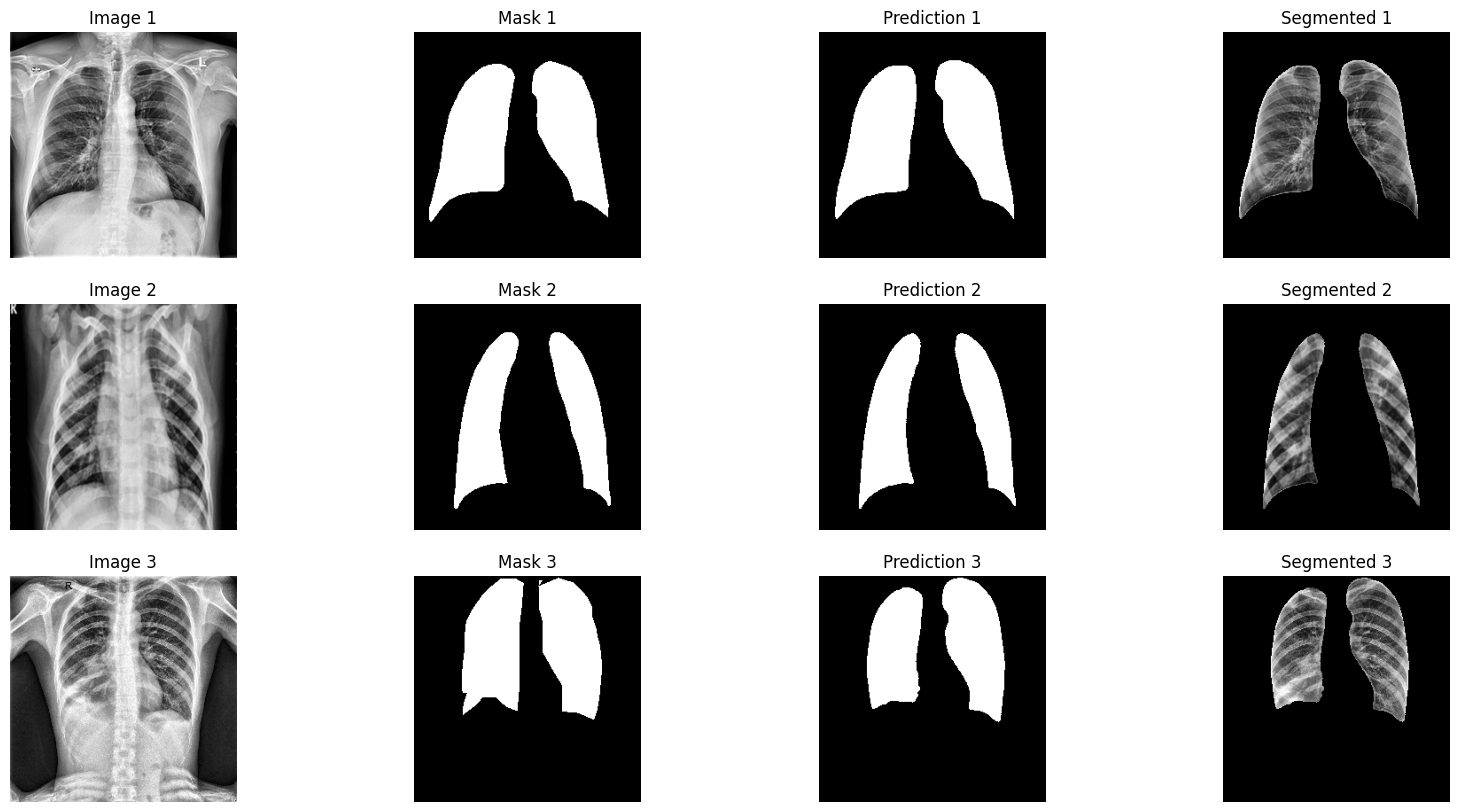

In [22]:
# Ambil 3 sampel acak dari data validasi
pred_candidates = np.random.randint(0, test_vol.shape[0], 3)

# Ambil gambar dan mask yang relevan dari validasi
sample_images = test_vol[pred_candidates]
sample_masks = test_seg[pred_candidates]

# Prediksi menggunakan model
preds = model.predict(sample_images)

# Terapkan threshold untuk mengonversi probabilitas menjadi biner (jika model menghasilkan probabilitas)
threshold = 0.5
preds_binary = (preds > threshold).astype(np.uint8)

# Buat plot untuk 3 sampel
plt.figure(figsize=(20, 10))  # Tambah lebar figure untuk kolom tambahan

for i in range(3):
    # Gambar asli
    plt.subplot(3, 4, 4*i+1)
    plt.imshow(np.squeeze(sample_images[i]), cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

    # Mask ground truth
    plt.subplot(3, 4, 4*i+2)
    plt.imshow(np.squeeze(sample_masks[i]), cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')

    # Prediksi mask
    plt.subplot(3, 4, 4*i+3)
    plt.imshow(np.squeeze(preds_binary[i]), cmap='gray')
    plt.title(f"Prediction {i+1}")
    plt.axis('off')

    # Hasil segmentasi (citra asli * prediksi mask)
    segmented_image = np.squeeze(sample_images[i]) * np.squeeze(preds_binary[i])
    plt.subplot(3, 4, 4*i+4)
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f"Segmented {i+1}")
    plt.axis('off')

# Simpan plot ke file
output_path = '/kaggle/working/segmentation_results_with_segmented_images.png'
plt.savefig(output_path, bbox_inches='tight')

# Tampilkan plot
plt.show()

# **Menyimpan Data Citra Pengujian**

In [21]:
import zipfile

# Simpan test_vol dan test_seg sebagai gambar PNG
for i in range(test_vol.shape[0]):
    cv2.imwrite(f'/kaggle/working/test_set/test_vol_{i}.png', test_vol[i, :, :, 0])
    cv2.imwrite(f'/kaggle/working/test_set/test_seg_{i}.png', test_seg[i, :, :, 0] * 255)

# Buat file ZIP
with zipfile.ZipFile('/kaggle/working/test_set/zip/gambar_test.zip', 'w') as zip_file:
    for file in os.listdir('/kaggle/working/test_set'):
        if file.endswith('.png'):
            zip_file.write(os.path.join('/kaggle/working/test_set', file), file)